Full-sample max monthly mean = 0.016114 (≈ 19.34% p.a.)
Setting TARGET = 0.75 * max = 0.012086 (≈ 14.50% p.a.)



/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:493: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local

Annualised Mean–Std Table (TARGET = 0.75 × max):

          Mean_%  Std_%
MV_in      14.50  15.51
NSMV_in    14.50  21.48
MIMV_in    14.50  23.07
MV_out     12.32  14.65
NSMV_out   13.24  17.23
MIMV_out   13.20  18.33


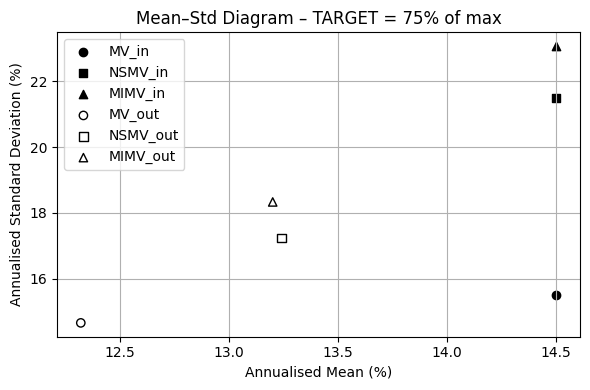

In [9]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ==============================================
# TARGET = 0.75 * max(full-sample mean)
# on the 25 Portfolios (5×5) Dataset
# ==============================================

# CONFIGURATION ------------------------------------------------------------
CSV_PATH = Path("25_Portfolios_5x5.csv")  # Loading Data
M        = 120                             # Rolling window length (months)
ANNU     = 12                              # For annualisation

# LOAD & CLEAN DATA --------------------------------------------------------
# Read raw lines to locate header at index 15
with open(CSV_PATH, "r") as f:
    lines = f.read().splitlines()

header_idx = 15  # Known location of the 25 portfolio names
raw_header = lines[header_idx].split(",")
column_names = ["Date"] + [h.strip() for h in raw_header if h.strip()]

# Load data starting from the line after header_idx
df = pd.read_csv(
    CSV_PATH,
    skiprows=header_idx + 1,
    sep=",",
    header=None,
    names=column_names,
    skipinitialspace=True,
    dtype=str
)

# Parse Date (YYYYMM → datetime); drop parse failures
df["Date"] = pd.to_datetime(df["Date"].str.strip(), format="%Y%m", errors="coerce")
df = df[~df["Date"].isna()].copy()
df.set_index("Date", inplace=True)

# Convert each portfolio return from percent-string to float decimal
for col in df.columns:
    df[col] = df[col].astype(float) / 100.0

# Remove duplicates, sort, then trim to July 1926 – December 2024
returns = df[~df.index.duplicated()].sort_index()
returns = returns[(returns.index >= "1926-07-01") & (returns.index <= "2024-12-01")]

if len(returns) < M + 1:
    raise ValueError("Insufficient data (<121 months) after cleaning. Check the CSV file.")

N     = returns.shape[1]      # Number of assets (25)
FLOOR = 1 / (2 * N)           # Floor = 1/(2N) for MIMV

# OPTIMISER FUNCTIONS -------------------------------------------------------
def mv_closed(mu, cov, r):
    """
    Closed-form unconstrained MV:
      minimize w' Σ w
      subject to sum(w)=1, μ' w = r
    """
    inv = np.linalg.inv(cov)
    e   = np.ones_like(mu)
    A = mu @ inv @ mu
    B = mu @ inv @ e
    C = e  @ inv @ e
    lam, gam = np.linalg.solve([[A, B], [B, C]], [r, 1])
    return lam * (inv @ mu) + gam * (inv @ e)

def qp_slsqp(mu, cov, r, lb):
    """
    Solve MV with:
      1) sum(w) = 1
      2) μ' w >= r
      3) w_i >= lb for all i
    via SLSQP. Return equal-weight 1/N if solver fails.
    """
    n  = len(mu)
    w0 = np.repeat(1 / n, n)

    objective = lambda w: w @ cov @ w
    cons = (
        {"type": "eq",   "fun": lambda w: w.sum() - 1},
        {"type": "ineq", "fun": lambda w: w @ mu - r}
    )
    bounds = [(lb, None)] * n

    res = minimize(objective, w0, method="SLSQP", bounds=bounds, constraints=cons,
                   options={"maxiter": 1000, "ftol": 1e-8, "disp": False})
    return np.asarray(res.x if res.success else w0)

# COMPUTE FULL-SAMPLE MEAN & COVARIANCE ------------------------------------------------
mu_full  = returns.mean().values
cov_full = np.cov(returns.T)

# DETERMINE TARGET = 0.75 * max(mu_full) ------------------------------------------------
max_mu = mu_full.max()
TARGET = 0.75 * max_mu

print(f"Full-sample max monthly mean = {max_mu:.6f} "
      f"(≈ {max_mu*ANNU*100:.2f}% p.a.)")
print(f"Setting TARGET = 0.75 * max = {TARGET:.6f} "
      f"(≈ {TARGET*ANNU*100:.2f}% p.a.)\n")

# IN-SAMPLE EVALUATION ------------------------------------------------------
w_mv_in   = mv_closed(mu_full, cov_full, TARGET)
w_nsmv_in = qp_slsqp(mu_full, cov_full, TARGET, lb=0)
w_mimv_in = qp_slsqp(mu_full, cov_full, TARGET, lb=FLOOR)

insample = pd.DataFrame({
    "MV_in":   returns.values @ w_mv_in,
    "NSMV_in": returns.values @ w_nsmv_in,
    "MIMV_in": returns.values @ w_mimv_in
}, index=returns.index)

# OUT-OF-SAMPLE EVALUATION --------------------------------------------------
outs_rows, outs_idx = [], []
for t in range(M, len(returns) - 1):
    window = returns.iloc[t - M : t]
    mu_t   = window.mean().values
    cov_t  = np.cov(window.T)

    w_mv_t   = mv_closed(mu_t, cov_t, TARGET)
    w_nsmv_t = qp_slsqp(mu_t, cov_t, TARGET, lb=0)
    w_mimv_t = qp_slsqp(mu_t, cov_t, TARGET, lb=FLOOR)

    next_ret = returns.iloc[t + 1].values
    outs_rows.append([next_ret @ w_mv_t, next_ret @ w_nsmv_t, next_ret @ w_mimv_t])
    outs_idx.append(returns.index[t + 1])

outsample = pd.DataFrame(
    outs_rows,
    index=outs_idx,
    columns=["MV_out", "NSMV_out", "MIMV_out"]
)

# SUMMARY STATS -------------------------------------------------------------
def annual_stats(series):
    mu_ann  = series.mean() * ANNU * 100
    std_ann = series.std(ddof=1) * np.sqrt(ANNU) * 100
    return pd.Series({"Mean_%": mu_ann, "Std_%": std_ann})

all_six = pd.concat([insample, outsample], axis=1)
table   = all_six.apply(annual_stats).T.round(2)

print("Annualised Mean–Std Table (TARGET = 0.75 × max):\n")
print(table)

# PLOT MEAN‐SD SCATTER -------------------------------------------------------
plt.figure(figsize=(6, 4))
markers = {"MV": "o", "NSMV": "s", "MIMV": "^"}

for strat in table.index:
    part = strat.split("_")[1]  # "in" or "out"
    key  = strat.split("_")[0]  # "MV", "NSMV", "MIMV"
    face = "none" if part == "out" else "black"
    plt.scatter(
        table.loc[strat, "Mean_%"],
        table.loc[strat, "Std_%"],
        marker=markers[key],
        edgecolor="black",
        facecolors=face,
        label=strat
    )

plt.xlabel("Annualised Mean (%)")
plt.ylabel("Annualised Standard Deviation (%)")
plt.title("Mean–Std Diagram – TARGET = 75% of max")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
